### Train a LSTM Neural Network on Vector representation of each document generated earlier & Predict the test documents similarly


##### Overview:

Step 1) Visualize Vector Representation: The vector values generated by document to vector algorithm have 400 dimensions ( 400 columns ) for each sample / text document. We will visualize how these distinct samples are grouped in 400 dimensions using TSNE.


Step 2) Pre-process Vector Representation: We will normalize each training document vector generated from Doc2Vec so that all samples have values on a common scale, for better accuracy while predicting values through Neural Network. 

    -> We will then reduce the dimensions, using PCA, in the train data's vector values to reduce the noise around input data and only pick up important features. We will inspect the *Intrinsic Dimensions* of the input data to give us a better idea on how to pick up the best features.
    
    -> We will also take a look at how these reduced dimensions seperate two different categories in the input data using TSNE.
    
    
Step 3) Train an LSTM Network: We will now train the LSTM Network on each training document which was vectorized, normalized and has reduced dimensions. 
    
    Architecture:
    
    -> We will use 3 LSTM based CELLS  to train on these input vectors and one output layer to predict probabilities of each training sample belonging to a category.
    
    -> Regularization: 
    
        a) *he-weight* initialization for better and uniform weight initialization. 
        
        b) Dropout for each of the LSTM Cells, to reduce over-fitting.
        
        c) 'ELU' activation was used to mitigate the vanishing and exploding gradients issue.
        
    -> Optimizer: Adam, to automatically adjust the learning rate for the data for better predictions.
        
    -> A simple accuracy score and a Confusion-matrix were used as an evaluation metric of the trained model.
    
    
    
Step 4) Load the test documents, follow a similar pre-processing steps as in Step 2, and transform in a format which is required by lstm network.


Step 5) Load the save files from Doc2Vec and LSTM network,  and predict on the test documents.


Step 6) Save the predicted labels in a text file seperated by a new line.
        
    
    

#### Importing necessary libraries

In [1]:
# For regular reading and writing of files
import pandas as pd
import numpy as np
import os


# For normalizing the input samples and splitting them for train and test samples seperately
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split


# For reducing the dimensions of the input data
from sklearn.decomposition import PCA


# For visualizations
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# To train a Neural network using keras and later load the trained file
from keras.models import Sequential, model_from_json
from keras.layers import Dense, LSTM, Dropout


# To recognise named entities in the text
import spacy
from nltk.tokenize import word_tokenize # For splitting sentences into words
from nltk.stem import WordNetLemmatizer # Lemmatize each word

from gensim.models.doc2vec import Doc2Vec


# To measure the accuracy of the predictions
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

Using TensorFlow backend.
C:\Users\amith\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
os.chdir('C:\\Users\\amith\\Desktop\\Toucan AI_Test') # Changing the current working directory

In [3]:
# Data which contains vector values for each document
train_data_vectors = pd.read_csv('Vectors_QNQ_Data.txt', 
            sep='\n',
            delimiter=',',
            header=None,
            engine='python')

# Data which contains text documents and their corresponding labels
train_text_data = pd.read_csv('QNQ.csv', engine='python')

In [4]:
features =train_data_vectors.values # Feature values which are in vectorized form

variety_labels = train_text_data['label'].values  # labels of each sample

#### Step 1

In [5]:
def Viz_TSNE(lr,
             X,
             y,
             dim = 0):
    
    '''This is a helper function which is used to train a TSNE algorithm on the feature values. After
    
    training the algorithm this function prints a scatter plot which shows how samples are distributed in higher dimensions.
    
    Inputs:
    
    1. lr: learning rate with which the algorithm learns. 
    
        Required. An integer.
        
    2. X: features values which TSNE learns on.
    
        Required. An array or a list of features.
        
    3. y: labels for the training data.
    
        Required. An array or a list of labels
        
    4. dim: variable to detect whether the visualization is before reducing dimensions or after.
    
        Optional. An integer either 0 or 1, 0 by default.
    '''
    
    # Variable for the end title
    st = 'before reducing dimensions'
    
    
    if dim == 0:
        
        pass
    
    else:
        
        st = 'after reducing dimensions'
    
    # Instantiating a TSNE object
    model = TSNE(learning_rate = lr)
    
    # Fitting and transforming to tsne features
    tsne_features = model.fit_transform(X)
    
    # First set of features
    f1= tsne_features[:,0]
    
    # Second set of features
    f2 = tsne_features[:,1]
    
    # Plotting a scatter plot
    plt.scatter(f1,f2,c=y)
    
        
    plt.title('Visualizing distributions of feature data across different output labels {}'.format(st))

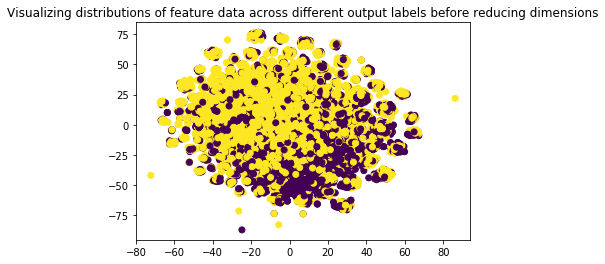

In [6]:
Viz_TSNE(300, # Learning rate 
         features, # features to train on
         variety_labels) # Labels for all the fearures

##### We can infer that the features for two distinct labels are not seperated all that well i.e., they are closely grouped.

#### Step 2

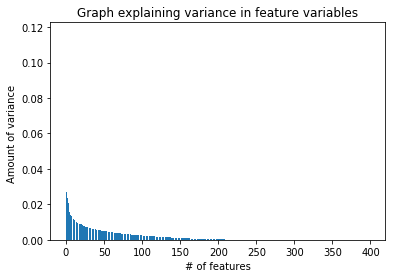

In [7]:
# Normalize the input features
nn = normalize(features)


normalized_features = nn

# instantiating a PCA model
pca_model = PCA()

# Fit / learn the weights for the features to a pca model
pca_model.fit(normalized_features)

posbl_fet = range( pca_model.n_components_ )

# Plotting a bar plot with features on x axis and their variance score on y axis
plt.bar(posbl_fet, pca_model.explained_variance_)

plt.title('Graph explaining variance in feature variables')

plt.xlabel('# of features')

plt.ylabel('Amount of variance ')

plt.show()

##### We can see that after the 100th feature there's no significant variance in the features, so our premise is to take the features with most variance in the input data so that they can better explain the dependent variable.

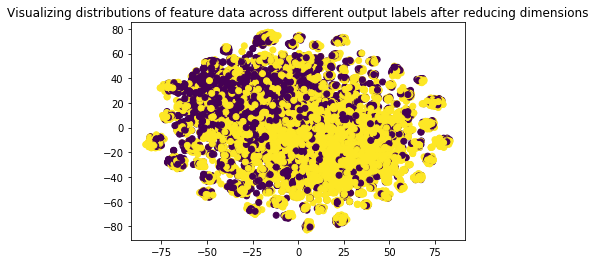

In [8]:
# Re instantiating a PCA model with only 100 components
pca_final_model = PCA(n_components=100)

# Fitting and transforming the input features
final_scaled_features = pca_final_model.fit_transform(normalized_features)


#CALL VIZ_TSNE
Viz_TSNE(300, # Learning rate 
         final_scaled_features, # Features
         variety_labels, # Distinct labels
         dim=1) # Label to depict viz after reducing dimensions

##### We can infer that features belonging to two different classes are slightly well seperated than the feature before dimensions being reduced. This seperation will help us while we're using a NN to predict labels.

In [9]:
final_scaled_features.shape

(12850, 100)

#### Step 3

In [10]:
class Train_PredictQues_LSTM():
    
    '''This class is used to train the vectors for each text document. 
    At the end of training of these vectors the model parameters and weights are saved 
    as a JSON and text files respectively.'''
    
    def __init__(self,
                 X, 
                 y, 
                 num_time_steps, 
                 num_dimensions, 
                 train_size, 
                 epochs):
        
        '''Constructor to instantiate all the hyper parameter variables. It internally calls a function to create a 
        dataset which is suited to train on a n lstm network.'''
        
        # Features
        self.X = X
        
        # Labels
        self.y = y
        
        # Num of time steps in which you unroll each data sample
        self.num_tsteps = num_time_steps
        
        # No. of columns or dimensions of each sample with in the time step
        self.num_dim = num_dimensions
        
        # Size of training samples
        self.tr_size = float( train_size )
        
        # Num of epochs
        self.epochs = epochs
        
        # Call the function to transform / reshape the data set
        self._make_dataset_LSTM()
        
    def _make_dataset_LSTM(self):
        
        '''Private internal function used to reshape the data set.The data is then re-shaped,
        
        it will split in to train and test variables. At the end this functions calls another internal function,
        
        which constructs and trains an lstm network.'''
        
        # Reshape the input features
        self.X = np.reshape( self.X, 
                            newshape= ( len(self.X), self.num_tsteps, self.num_dim )  # 3D Tensor of the input variables
                           )

        
        # Split the features and labels in to train and test 
        self.X_train,self.X_test,self.y_train,self.y_test = train_test_split(
            self.X,
            self.y, 
            train_size = self.tr_size)
        
        
        # Call the function to train the network
        self._Train_LSTM()
         
    def _Train_LSTM(self):
        
        '''This is a private internal function used to construct 3 LSTM cells with dropout and other paramters,
        
        this model uses a sigmoid activation function for the output layer to predict different classes of the targets. '''
        
        # Instantiate a sequential layers for the network
        self.lstm_model = Sequential()
        
        
        #Dropout for the input layer
        self.lstm_model.add(
            
            Dropout(0.2, input_shape=(self.num_tsteps, self.num_dim))      )
        
        # First LSTM Cell
        self.lstm_model.add(
            
            LSTM (self.X.shape[2], # Num of neurons in the layer of the cell
                  
                  return_sequences=True, # Return a vector to the next lstm cell
                  
                input_shape= (self.num_tsteps, self.num_dim), # Shape of feature in each time step
                  
                  activation='elu', # Activation for initial layer
                  
                  recurrent_activation = 'elu', # Activation for the recurrent layer
                  
                  kernel_initializer='he_uniform', # Weight initialization for the initial layer
                  
                  recurrent_initializer='he_uniform', # Weights for the unrolled layer
                  
                  use_bias=True # Bias node 
                  
                

                             ))
        
        
        # Dropout for the next LSTM CELL
        self.lstm_model.add(
            
            Dropout(0.3)      )
        
        
        # Second LSTM Cell
        self.lstm_model.add(
            
            LSTM (self.X.shape[2], return_sequences=True,
                  
                input_shape= (self.num_tsteps, self.num_dim), activation='elu',
                  
                  recurrent_activation = 'elu', kernel_initializer='he_uniform', recurrent_initializer='he_uniform',
                  
                  use_bias=True

                             ))
        
        # Dropout for the third LSTM CELL
        self.lstm_model.add(
            
            Dropout(0.3)      )
        
        
        
        # 3rd LSTM Cell
        self.lstm_model.add(
            
            LSTM (self.X.shape[2] ))
        
        
        
        
        # Output Layer with 1 neuron
        self.lstm_model.add(Dense(1, activation='sigmoid'))
        
        #Execute the Model
        self.lstm_model.compile(loss='binary_crossentropy', metrics = ['accuracy'], optimizer='adam')
        
        # Fit or learn the weights for the training samples
        self.lstm_model.fit(self.X_train, self.y_train , 
                       epochs=self.epochs, batch_size= len(self.X_train) ,
                       verbose=0) # To not print accuracies or losses in each epoch
        
        
        # Call an internal function to predict
        self._Predict_LSTM()    
    
    def _Predict_LSTM(self):
        
        '''This is a private internal function used to predict on the trained weights of the model.'''
        
        # evaluate the model
        avg_accuracy = self.lstm_model.evaluate(self.X_test,self.y_test,verbose=0)
        
        print(" Test Accuracy: %.2f%%" % (avg_accuracy[1]*100), '\n')
        
        
        # Predicting labels for each test sample
        self.predictions = self.lstm_model.predict_classes(self.X_test,
                                              batch_size = len(self.X_test)
                                             )
        
        # Calculating accuracy and confusion matrix for the test samples
        print('Accuracy of predictions: \n', accuracy_score(self.y_test, self.predictions.flatten()), '\n',
             
             'Confusion Matrix: \n', confusion_matrix(self.y_test, self.predictions.flatten()))

        # serialize model to JSON
        model_json = self.lstm_model.to_json()
        
        with open("lstm_model.json", "w") as json_file:
            json_file.write(model_json)
            
        # serialize weights to HDF5
        self.lstm_model.save_weights("lstm_model_weights.h5")
        print("Saved model to disk")    

In [11]:
obj = Train_PredictQues_LSTM(final_scaled_features, # Feature variables
                      variety_labels, # Labels
                      4, # Num of time steps
                      25, # No of features in each time step
                      0.9, # Training size
                      1300) # Num of epochs

C:\Users\amith\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


 Test Accuracy: 75.95% 

Accuracy of predictions: 
 0.7595330739299611 
 Confusion Matrix: 
 [[209 237]
 [ 72 767]]
Saved model to disk


###### Of all the data points which are actually labelled 1, 767 of them were properly predicted as 1 by our model (TN) and 237 of data points were mis classified as 1's while they were not ( FN ). Similarly, 209 were properly classified  as 0's by our model (  TP ) and 72 were mis classified as 0' ( FP ). 

#### Step 4

In [12]:
# Spacy object to load all entities in the english language
spec = spacy.load('en')

#Lemmatizer object to lemmatize each word to its base form
lem_obj = WordNetLemmatizer()

In [13]:
def clean_text(data):
    
    '''This is a helper function which pre-processes the text in a format which can be fed 
    to a Doc2Vec to train the sentences.
    
    
    Inputs:
    
    data: A list of strings. Shape = N documents
    
    Outputs: A list of strings. Shape = N documents
    
    Steps:
    
    a -> for each sentence in the text data, convert it to string (to avoid special character issues) and look for any named
    entities in that particular sentence. Entities such as name of a person and date will be replaced in the string.
    
    b-> The sentence would then be tokenized into individual words, transformed to lower case, and then lemmatized ( turning into its base form)
    A word is only lemmatized if it either a digit or an alphabet ( to avoid special characters)
    
    c-> This *cleaned* sentence is then appended to a list as a single line.
    
    d-> This process continues untill all the sentences in the input data are iterated over and finally this method returns
    
    a list of strings, where each index contains a sentence which is pre-processed.
    '''
    
    # List to hold the cleaned strings
    fd = []
    
    # Iterating over each sentence 
    for sent in data:
        
        # Convert it to string , to avoid encoding issues
        sent = str( sent[0] )
        
        # Identify named entities in this string
        ne = spec(sent)
        
        # Iterating over each named entity in the string
        for ents in ne.ents:
            
            # If an entity like PERSON's name or DATE is in this string,
            # replace that with an empty string
            if ents.label_ is "PERSON" or ents.label_ is "DATE":
                
                sent = sent.replace(ents.text, '')
        
        # After removing such entities, tokenize sentence into individual words,
        # if a word is an alphabet or a digit only then add that word to a sentence by converting it to base form : lemmatizing
        result = ' '.join([lem_obj.lemmatize(word.lower())
                           for word in word_tokenize(sent) if word.isalpha() or word.isdigit() ]) 
        
        # Add the resulting clean string to the final list
        fd.append(result)
        
        
    # Return a list containing all the cleaned strings in each row
    return fd    

In [14]:
test_docs = clean_text(   pd.read_csv('C:\\Users\\amith\\Desktop\\Toucan AI_Test\\datasets_test\\Testsent.txt',
                        sep='\r\n',
                        encoding='utf-8',
                        engine='python', header=None).values.tolist()        )

In [15]:
len(test_docs)

24295

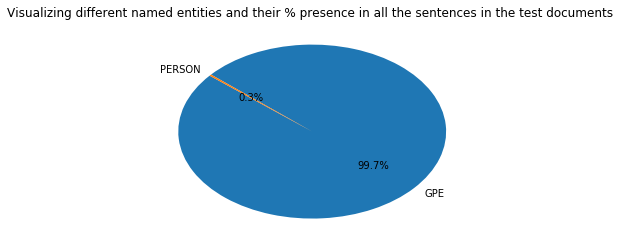

In [16]:
labels = [] # List to hold different named entities in the original text sentences which were not cleaned

#  iterating over all test documents
for doc in test_docs:
    
    # Identifying named entities in that sentence
    entities = spec(doc)
    
    # List to hold different labels of our interest
    req_lab = ["FACILITY", "LOCATION", "ORGANIZATION", "GPE", "PERSON"]
    
    # Iterating over each named entity in the  string
    for ent in entities.ents:
        
        # If this label is in our required labels 
        if ent.label_ in req_lab:
            
            # Append that label to the list
            labels.append(ent.label_);
            
# Identifying unique labels and counting the occurence of each label                                   
unq_lab ,values = np.unique(labels, return_counts=True)



plt.pie(values, labels=unq_lab, autopct='%1.1f%%', startangle=140)


plt.title('Visualizing different named entities and their % presence in all the sentences in the test documents ')

# Display the chart
plt.show()

##### Most of the documents in our text document contains named entities such as a Geo Political Entity ( ex: names of Landmarks )

#### Step 5

In [17]:
os.chdir('C:\\Users\\amith\\Desktop\\Toucan AI_Test')

In [18]:
# Load the trained document2 Vec object to generate float vector representation for each of the test documents

doc2vec_obj = Doc2Vec.load('Ques_Classify_vectors.doc2vec')




# Transforming each text document in the training file into a vector representation
raw_features_test_docs = [doc2vec_obj.infer_vector(    str(doc)  ) for doc in test_docs]



# Convert each 400-dimensioned test vector to fewer dimensions
features_test_docs = pca_final_model.fit_transform(raw_features_test_docs)



# Reshape the documents to align with architecture of the trained model
features_test_docs = np.reshape(features_test_docs, newshape=(  len(features_test_docs), 4, 25)        )

In [19]:
# load json and create model
json_file = open('lstm_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()


loaded_lstm_model = model_from_json(loaded_model_json)


# load weights into new model
loaded_lstm_model.load_weights("lstm_model_weights.h5")
print("Loaded model from disk")


# evaluate loaded model on test data
loaded_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Loaded model from disk


In [20]:
len(features_test_docs)

24295

In [21]:
preds = loaded_lstm_model.predict_classes(x=features_test_docs, batch_size=  len(features_test_docs),verbose=0   )

C:\Users\amith\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\sequential.py:276: RuntimeWarning: invalid value encountered in greater
  return (proba > 0.5).astype('int32')


In [22]:
len(preds.flatten())

24295

In [23]:
final_predicted_labels = np.array(preds.flatten(), dtype = int)

#### Step 6

In [24]:
np.savetxt( 'Predicted_Labels_QNQ.txt',  final_predicted_labels,delimiter = '\n', fmt = '%d')